In [1]:
import pandas as pd
import numpy as np
import json
import keras
import random
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential, load_model
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)

for elem in range(len(data_lines)):
    for arr in range(len(data_lines[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_lines[elem][arr][f])
        data_lines[elem][arr] = tmp

In [3]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)

for elem in range(len(data_circles)):
    for arr in range(len(data_circles[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_circles[elem][arr][f])
        data_circles[elem][arr] = tmp
        

In [4]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)
    

def generator(data, labels):
    assert len(data) == len(labels)
    while True:
        for elem in range(len(data)):
            #word_array = []
            #for arr in range(len(data[elem])):
            #    tmp = []
            #    for f in range(7):
            #        tmp.append(data[elem][arr][f])
            #    word_array.append(tmp)
            yield np.array(data[elem]), np.array(labels[elem])

g_lines = generator(data_lines, [1] * len(data_lines))

In [5]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)
    
g_circles = generator(data_circles, [0] * len(data_circles))

In [6]:
with open('../dati/dati_con_penna/concatenati/pad/dario_1_concat_dario_2_pad.json', 'r') as f:
    data_d = json.load(f)
    
g_dario = generator(data_d[:-3], [1] * 7)
g_dario_test = generator(data_d[-3:], [1] * 3)

In [7]:
with open('../dati/dati_con_penna/concatenati/pad/antonio_1_concat_antonio_2_pad.json', 'r') as f:
    data_a = json.load(f)
    
g_antonio = generator(data_a[:-3], [0] * 8)
g_antonio_test = generator(data_a[-3:], [0] * 3)

In [8]:
with open('../dati/dati_con_penna/concatenati/pad/manuel_1_concat_manuel_2_pad.json', 'r') as f:
    data_t = json.load(f)
    
g_taraz = generator(data_t[:-3], [0] * 7)
g_taraz_test = generator(data_t[-3:], [0] * 3)

In [9]:
with open('../dati/dati_con_penna/concatenati/pad/giovanni_1_concat_giovanni_2_pad.json', 'r') as f:
    data_g = json.load(f)
    
g_giovanni = generator(data_g[:-3], [0] * 5)
g_giovanni_test = generator(data_g[-3:], [0] * 3)

In [10]:
labelled_data_d, labelled_data_g = [], []
for i in range(len(data_d)):
    labelled_data_d.append((data_d[i], 1))

for i in range(len(data_g)):
    labelled_data_g.append((data_g[i], 0))
    
for i in range(len(data_a)):
    labelled_data_g.append((data_a[i], 0))

for i in range(len(data_t)):
    labelled_data_g.append((data_t[i], 0))

In [11]:
labelled_data_dg = labelled_data_d + labelled_data_g  
random.shuffle(labelled_data_dg)

In [12]:
def xy_data(labelled_data):
    x_data, y_labels = [], []
    for i in labelled_data:
        x_data.append(i[0])
        y_labels.append(i[1])
        
    return np.array(x_data), np.array(y_labels)

data_dg, label_dg = xy_data(labelled_data_dg)
print(data_dg.shape)

(196, 600, 7)


In [13]:
def mix_generator(g1, g2, batch_size):
    while True:
        batch = []
        label = []
        for _ in range(batch_size // 2):
            tmp = next(g1)
            batch.append(tmp[0])
            label.append(tmp[1])
            tmp = next(g2)
            batch.append(tmp[0])
            label.append(tmp[1])
        print(np.array(label).shape)
        yield np.array(batch), np.array(label)

g_mix = mix_generator(g_lines, g_circles, 10)
g_dario_giovanni = mix_generator(g_dario, g_giovanni, 10)
g_dario_antonio = mix_generator(g_dario, g_antonio, 10)
g_dario_taraz = mix_generator(g_dario, g_taraz, 10)
g_dario_giovanni_antonio = mix_generator(g_dario_giovanni, g_dario_antonio, 10)
g_dario_tutti = mix_generator(g_dario_giovanni_antonio, g_dario_taraz, 10)

In [14]:
def generator_one_against_all(path_genuine, paths_impostors, batch_size):
    with open(path_genuine, 'r') as f:
        genuine_data = json.load(f)
        
    train_ratio = round(len(genuine_data) / 5)
    assert len(genuine_data[:-train_ratio]) + len(genuine_data[-train_ratio:]) == len(genuine_data)
    genuine_generator = generator(genuine_data[:-train_ratio], [1] * (len(genuine_data) - train_ratio))
    genuine_generator_test = generator(genuine_data[-train_ratio:], [1] * train_ratio)
    
    generator_all = genuine_generator
    generator_all_test = genuine_generator_test
    
    for path in paths_impostors:
        with open(path, 'r') as f:
            impostor_data = json.load(f)
        train_ratio = round(len(impostor_data) / 5)
        assert len(impostor_data[:-train_ratio]) + len(impostor_data[-train_ratio:]) == len(impostor_data)
        generator_all = mix_generator(generator_all, generator(impostor_data[:-train_ratio], [0] * (len(impostor_data) - train_ratio)), batch_size)
        generator_all_test = mix_generator(generator_all_test, generator(impostor_data[-train_ratio:], [0] * train_ratio), batch_size)
        
    return generator_all, generator_all_test

impostors = ['../dati/pad/giovanni_pad.json', '../dati/pad/taraz_pad.json']
g_dario_impostors, g_dario_impostors_test = generator_one_against_all('../dati/pad/dario_pad.json', impostors, 10)

In [15]:
model_dario = Sequential()
model_dario.add(LSTM(input_shape=(600, 7), units=200, activation="sigmoid", return_sequences=True, recurrent_activation="hard_sigmoid"))
model_dario.add(LSTM(units=200, activation="sigmoid", return_sequences=False, recurrent_activation="hard_sigmoid"))
model_dario.add(Dropout(0.5))
model_dario.add(Dense(1, activation='sigmoid'))

In [16]:
model_dario.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'roc_curve'])

In [17]:
plot_model(model_dario, show_shapes=True, to_file='lstm_dropout_model.png')

In [18]:
#hist = model_dario.fit_generator(g_dario_impostors, epochs=5, steps_per_epoch=42)
#!git add .
#!git commit -m 'aggiunti primi grafici'
#!git push 

In [19]:
hist = model_dario.fit(x = data_dg, y = label_dg, epochs=131, steps_per_epoch=10, validation_split=0.33, validation_steps=65)

Train on 131 samples, validate on 65 samples
Epoch 1/131
10/10 [==============================] - 26s 3s/step - loss: 0.5629 - acc: 0.7611 - val_loss: 0.6072 - val_acc: 0.6923
Epoch 2/131
10/10 [==============================] - 25s 3s/step - loss: 0.5141 - acc: 0.7771 - val_loss: 0.6379 - val_acc: 0.6923
Epoch 3/131
10/10 [==============================] - 25s 3s/step - loss: 0.4963 - acc: 0.7695 - val_loss: 0.6466 - val_acc: 0.6923
Epoch 4/131
10/10 [==============================] - 25s 3s/step - loss: 0.4838 - acc: 0.7725 - val_loss: 0.6867 - val_acc: 0.6923
Epoch 5/131
10/10 [==============================] - 25s 2s/step - loss: 0.4756 - acc: 0.7786 - val_loss: 0.6887 - val_acc: 0.6923
Epoch 6/131
10/10 [==============================] - 25s 3s/step - loss: 0.4702 - acc: 0.7756 - val_loss: 0.6876 - val_acc: 0.6923
Epoch 7/131
10/10 [==============================] - 25s 3s/step - loss: 0.4591 - acc: 0.7779 - val_loss: 0.7080 - val_acc: 0.6923
Epoch 8/131
10/10 [===================

Epoch 63/131
10/10 [==============================] - 25s 3s/step - loss: 0.2967 - acc: 0.9031 - val_loss: 0.2925 - val_acc: 0.9231
Epoch 64/131
10/10 [==============================] - 25s 3s/step - loss: 0.0260 - acc: 0.9985 - val_loss: 0.2874 - val_acc: 0.9385
Epoch 65/131
10/10 [==============================] - 25s 3s/step - loss: 0.0097 - acc: 1.0000 - val_loss: 0.3270 - val_acc: 0.9385
Epoch 66/131
10/10 [==============================] - 25s 3s/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.4461 - val_acc: 0.9231
Epoch 67/131
10/10 [==============================] - 25s 2s/step - loss: 0.4597 - acc: 0.8924 - val_loss: 0.3421 - val_acc: 0.8923
Epoch 68/131
10/10 [==============================] - 25s 3s/step - loss: 0.0179 - acc: 1.0000 - val_loss: 0.3543 - val_acc: 0.9231
Epoch 69/131
10/10 [==============================] - 25s 2s/step - loss: 0.0090 - acc: 1.0000 - val_loss: 0.3934 - val_acc: 0.9231
Epoch 70/131
10/10 [==============================] - 25s 3s/step - loss: 0.

10/10 [==============================] - 26s 3s/step - loss: 2.1304e-04 - acc: 1.0000 - val_loss: 0.5806 - val_acc: 0.9385
Epoch 125/131
10/10 [==============================] - 25s 3s/step - loss: 1.3231e-04 - acc: 1.0000 - val_loss: 0.6050 - val_acc: 0.9385
Epoch 126/131
10/10 [==============================] - 26s 3s/step - loss: 9.8922e-05 - acc: 1.0000 - val_loss: 0.6340 - val_acc: 0.9385
Epoch 127/131
10/10 [==============================] - 25s 3s/step - loss: 5.6010e-05 - acc: 1.0000 - val_loss: 0.5168 - val_acc: 0.9538
Epoch 128/131
10/10 [==============================] - 25s 3s/step - loss: 3.8112e-05 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9385
Epoch 129/131
10/10 [==============================] - 25s 3s/step - loss: 1.2644 - acc: 0.8435 - val_loss: 0.5532 - val_acc: 0.8769
Epoch 130/131
10/10 [==============================] - 26s 3s/step - loss: 0.0479 - acc: 0.9855 - val_loss: 0.4432 - val_acc: 0.9231
Epoch 131/131
10/10 [==============================] - 26s 3s/s

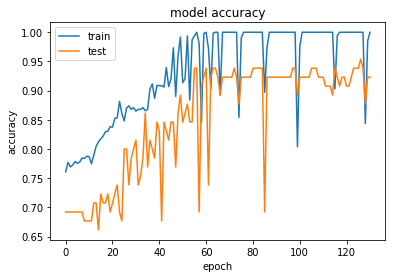

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./model_accuracy_131Epoch',quality=100,)

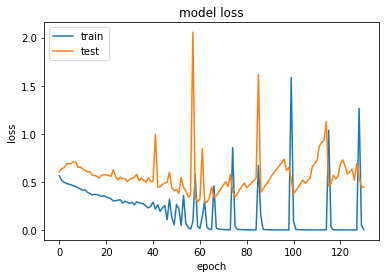

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./model_loss_131Epoch')

In [22]:
model_dario.save("model_dario.h5")
del model_dario

In [23]:
model_dario_reloaded = load_model("model_dario.h5")

In [24]:
out_dario_reloaded = model_dario_reloaded.evaluate_generator(g_dario_test, verbose=1, steps=3)

out_dario_reloaded

ValueError: Error when checking input: expected lstm_1_input to have 3 dimensions, but got array with shape (600, 7)